In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

GA: Pop=20, Mut=0.0001, Cross=0.5
GA: Pop=20, Mut=0.0001, Cross=0.7
GA: Pop=20, Mut=0.0001, Cross=0.9
GA: Pop=20, Mut=0.01, Cross=0.5
GA: Pop=20, Mut=0.01, Cross=0.7
GA: Pop=20, Mut=0.01, Cross=0.9
GA: Pop=20, Mut=0.05, Cross=0.5
GA: Pop=20, Mut=0.05, Cross=0.7
GA: Pop=20, Mut=0.05, Cross=0.9
GA: Pop=20, Mut=0.1, Cross=0.5
GA: Pop=20, Mut=0.1, Cross=0.7
GA: Pop=20, Mut=0.1, Cross=0.9
GA: Pop=20, Mut=0.5, Cross=0.5
GA: Pop=20, Mut=0.5, Cross=0.7
GA: Pop=20, Mut=0.5, Cross=0.9
GA: Pop=50, Mut=0.0001, Cross=0.5
GA: Pop=50, Mut=0.0001, Cross=0.7
GA: Pop=50, Mut=0.0001, Cross=0.9
GA: Pop=50, Mut=0.01, Cross=0.5
GA: Pop=50, Mut=0.01, Cross=0.7
GA: Pop=50, Mut=0.01, Cross=0.9
GA: Pop=50, Mut=0.05, Cross=0.5
GA: Pop=50, Mut=0.05, Cross=0.7
GA: Pop=50, Mut=0.05, Cross=0.9
GA: Pop=50, Mut=0.1, Cross=0.5
GA: Pop=50, Mut=0.1, Cross=0.7
GA: Pop=50, Mut=0.1, Cross=0.9
GA: Pop=50, Mut=0.5, Cross=0.5
GA: Pop=50, Mut=0.5, Cross=0.7
GA: Pop=50, Mut=0.5, Cross=0.9
GA: Pop=100, Mut=0.0001, Cross=0.5
GA: P

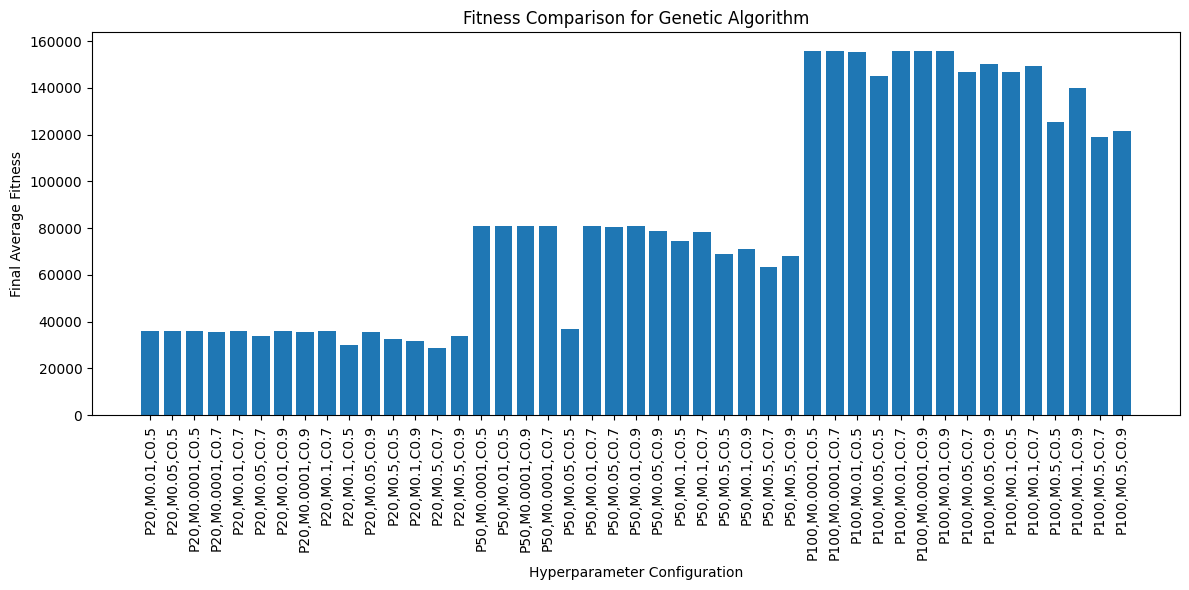

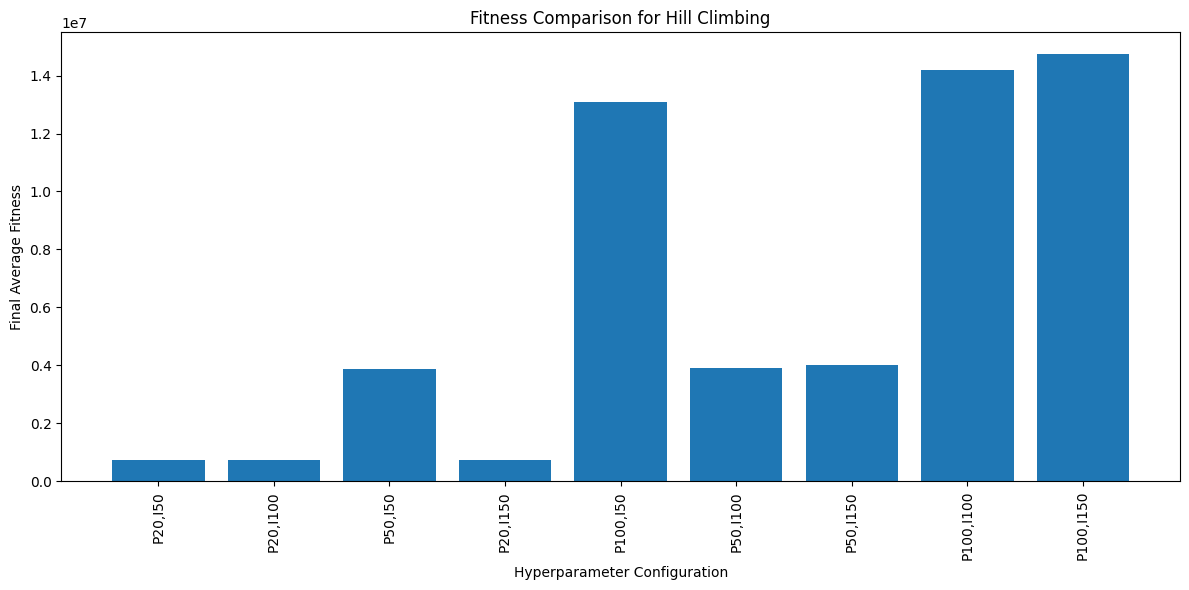

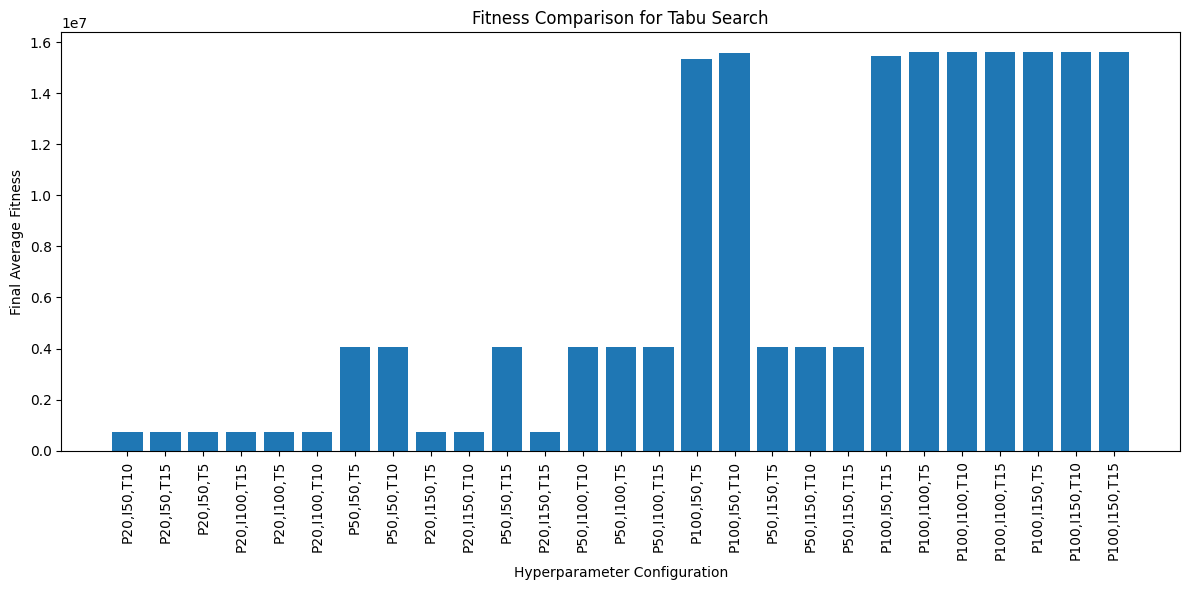

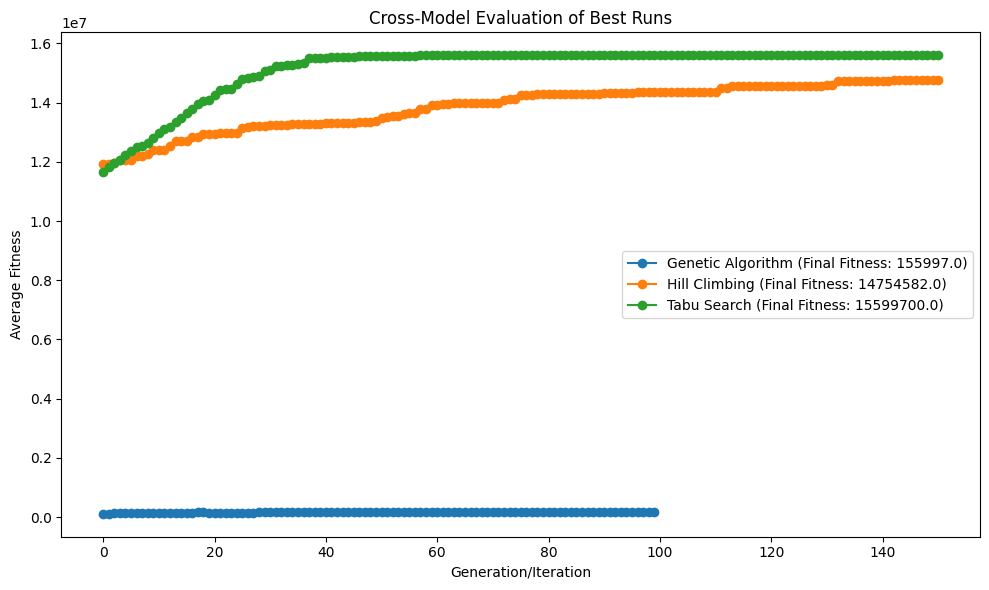

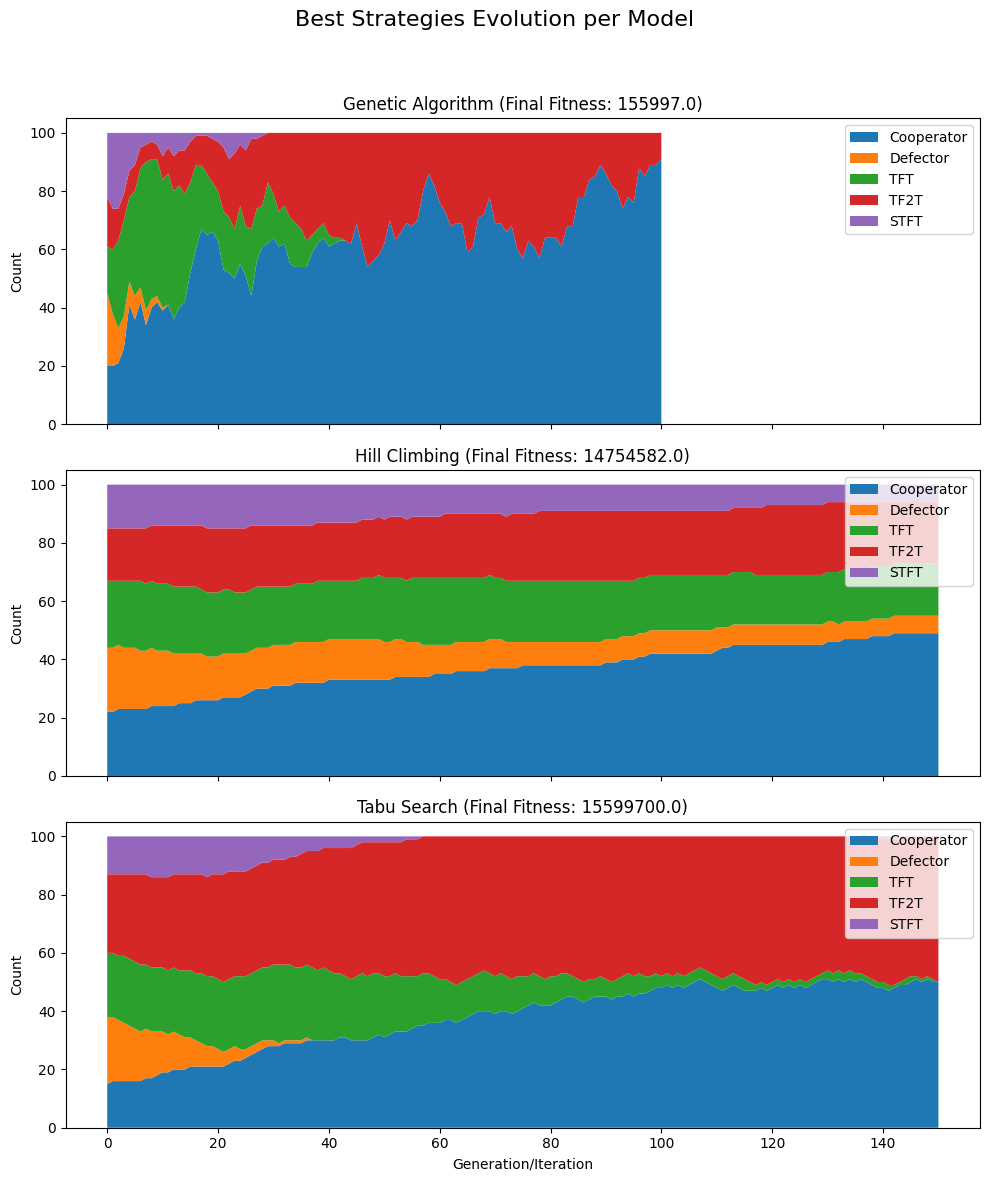

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import time
import concurrent.futures
import pandas as pd

# --------------------------
# JIT-accelerated Simulation Functions
# --------------------------
@njit
def simulate_game(strat_a, strat_b, rounds):
    """
    Simulate an iterated Prisoner's Dilemma game between two strategies.
    
    Strategy codes:
      0: Always Cooperate  
      1: Always Defect  
      2: Tit-for-Tat (TFT): Cooperate first, then mimic opponent's last move.  
      3: Tit-for-Two-Tats (TF2T): Cooperate for two rounds; then defect if opponent defected in both previous rounds.  
      4: Suspicious Tit-for-Tat (STFT): Defect first, then mimic opponent's last move.  
      5: Grim Trigger: Cooperate until opponent defects once, then always defect.  
      6: Win-Stay, Lose-Shift (WSLS): Start with cooperate; if last payoff < 3, switch; otherwise repeat.
    """
    payoff_a = 0.0
    payoff_b = 0.0

    # Memory for TFT, TF2T, STFT
    last_move_a = 0
    last_move_b = 0
    second_last_move_a = 0
    second_last_move_b = 0

    # For Grim Trigger strategies
    grim_triggered_a = False
    grim_triggered_b = False

    # For WSLS strategies
    wsls_last_move_a = 0
    wsls_last_move_b = 0
    wsls_last_payoff_a = 0.0
    wsls_last_payoff_b = 0.0

    for r in range(rounds):
        # --- Determine move for player A ---
        if strat_a == 0:  # Always Cooperate
            move_a = 0
        elif strat_a == 1:  # Always Defect
            move_a = 1
        elif strat_a == 2:  # TFT
            move_a = 0 if r == 0 else last_move_b
        elif strat_a == 3:  # TF2T
            if r < 2:
                move_a = 0
            else:
                move_a = 1 if (last_move_b == 1 and second_last_move_b == 1) else 0
        elif strat_a == 4:  # STFT
            move_a = 1 if r == 0 else last_move_b
        elif strat_a == 5:  # Grim Trigger
            if r == 0:
                move_a = 0
            else:
                move_a = 1 if grim_triggered_a else 0
        elif strat_a == 6:  # WSLS
            if r == 0:
                move_a = 0
            else:
                move_a = 1 - wsls_last_move_a if wsls_last_payoff_a < 3 else wsls_last_move_a
        else:
            move_a = 0

        # --- Determine move for player B ---
        if strat_b == 0:
            move_b = 0
        elif strat_b == 1:
            move_b = 1
        elif strat_b == 2:  # TFT
            move_b = 0 if r == 0 else last_move_a
        elif strat_b == 3:  # TF2T
            if r < 2:
                move_b = 0
            else:
                move_b = 1 if (last_move_a == 1 and second_last_move_a == 1) else 0
        elif strat_b == 4:  # STFT
            move_b = 1 if r == 0 else last_move_a
        elif strat_b == 5:  # Grim Trigger
            if r == 0:
                move_b = 0
            else:
                move_b = 1 if grim_triggered_b else 0
        elif strat_b == 6:  # WSLS
            if r == 0:
                move_b = 0
            else:
                move_b = 1 - wsls_last_move_b if wsls_last_payoff_b < 3 else wsls_last_move_b
        else:
            move_b = 0

        # --- Compute round payoff ---
        if move_a == 0 and move_b == 0:
            round_payoff_a, round_payoff_b = 3.0, 3.0
        elif move_a == 0 and move_b == 1:
            round_payoff_a, round_payoff_b = 0.0, 5.0
        elif move_a == 1 and move_b == 0:
            round_payoff_a, round_payoff_b = 5.0, 0.0
        else:
            round_payoff_a, round_payoff_b = 1.0, 1.0

        payoff_a += round_payoff_a
        payoff_b += round_payoff_b

        # --- Update memory for TFT, TF2T, STFT ---
        second_last_move_a = last_move_a
        second_last_move_b = last_move_b
        last_move_a = move_a
        last_move_b = move_b

        # --- Update Grim Trigger flags ---
        if strat_a == 5 and move_b == 1:
            grim_triggered_a = True
        if strat_b == 5 and move_a == 1:
            grim_triggered_b = True

        # --- Update WSLS state ---
        if strat_a == 6:
            wsls_last_payoff_a = round_payoff_a
            wsls_last_move_a = move_a
        if strat_b == 6:
            wsls_last_payoff_b = round_payoff_b
            wsls_last_move_b = move_b

    return payoff_a, payoff_b

@njit(parallel=True)
def evaluate_population(population, rounds):
    """
    Evaluate fitness for each individual by playing against every other individual.
    """
    n = population.shape[0]
    fitness = np.zeros(n, dtype=np.float64)
    for i in prange(n):
        for j in range(n):
            if i != j:
                payoff, _ = simulate_game(population[i], population[j], rounds)
                fitness[i] += payoff
    return fitness

# --------------------------
# Genetic Algorithm Function (with human competition)
# --------------------------
def genetic_algorithm(population_size, mutation_rate, crossover_rate, generations, game_rounds, compete_with_humans=True):
    """
    Run the genetic algorithm.
    
    If compete_with_humans is True, extra fitness is added from matches against 
    human-designed strategies: TFT (2), TF2T (3), STFT (4), Grim Trigger (5), WSLS (6).
    
    The evolving population uses strategies 0-4.
    """
    population = np.random.randint(0, 5, population_size)
    fitness_history = []
    strategies_history = []
    counts = (np.sum(population == 0),
              np.sum(population == 1),
              np.sum(population == 2),
              np.sum(population == 3),
              np.sum(population == 4))
    strategies_history.append(counts)

    for gen in range(generations):
        fitness = evaluate_population(population, game_rounds)
        if compete_with_humans:
            for i in range(population_size):
                for human in (2, 3, 4, 5, 6):
                    fitness[i] += simulate_game(population[i], human, game_rounds)[0]
        avg_fitness = np.mean(fitness)
        fitness_history.append(avg_fitness)
        total_fitness = np.sum(fitness)
        if total_fitness > 0:
            probabilities = fitness / total_fitness
        else:
            probabilities = np.ones(population_size) / population_size
        new_population = np.empty_like(population)
        for i in range(population_size):
            parent1 = population[np.random.choice(np.arange(population_size), p=probabilities)]
            parent2 = population[np.random.choice(np.arange(population_size), p=probabilities)]
            child = np.random.choice([parent1, parent2]) if np.random.rand() < crossover_rate else parent1
            if np.random.rand() < mutation_rate:
                child = np.random.randint(0, 5)
            new_population[i] = child
        population = new_population
        counts = (np.sum(population == 0),
                  np.sum(population == 1),
                  np.sum(population == 2),
                  np.sum(population == 3),
                  np.sum(population == 4))
        strategies_history.append(counts)
    
    return counts, fitness_history, strategies_history

# --------------------------
# Hill Climbing Optimization
# --------------------------
def hill_climb_optimization(population_size, iterations, game_rounds, compete_with_humans=True):
    """
    Hill Climbing: Change one individual's strategy per iteration.
    Accept the change if total fitness improves.
    """
    population = np.random.randint(0, 5, population_size)
    fitness_arr = evaluate_population(population, game_rounds)
    if compete_with_humans:
        for i in range(population_size):
            for human in (2, 3, 4, 5, 6):
                fitness_arr[i] += simulate_game(population[i], human, game_rounds)[0]
    current_fitness = np.sum(fitness_arr)
    fitness_history = [current_fitness]
    counts_history = [(np.sum(population == 0),
                       np.sum(population == 1),
                       np.sum(population == 2),
                       np.sum(population == 3),
                       np.sum(population == 4))]
    for it in range(iterations):
        idx = np.random.randint(0, population_size)
        new_strategy = np.random.choice([s for s in range(5) if s != population[idx]])
        new_population = population.copy()
        new_population[idx] = new_strategy
        new_fitness_arr = evaluate_population(new_population, game_rounds)
        if compete_with_humans:
            for i in range(population_size):
                for human in (2, 3, 4, 5, 6):
                    new_fitness_arr[i] += simulate_game(new_population[i], human, game_rounds)[0]
        new_total_fitness = np.sum(new_fitness_arr)
        if new_total_fitness > current_fitness:
            population = new_population
            current_fitness = new_total_fitness
        fitness_history.append(current_fitness)
        counts_history.append((np.sum(population == 0),
                               np.sum(population == 1),
                               np.sum(population == 2),
                               np.sum(population == 3),
                               np.sum(population == 4)))
    return population, fitness_history, counts_history

# --------------------------
# Tabu Search Optimization
# --------------------------
def tabu_search_optimization(population_size, iterations, game_rounds, tabu_size, compete_with_humans=True):
    """
    Tabu Search: Sample candidate moves and choose the best non-tabu move.
    Prevent cycling with a tabu list.
    """
    population = np.random.randint(0, 5, population_size)
    fitness_arr = evaluate_population(population, game_rounds)
    if compete_with_humans:
        for i in range(population_size):
            for human in (2, 3, 4, 5, 6):
                fitness_arr[i] += simulate_game(population[i], human, game_rounds)[0]
    current_fitness = np.sum(fitness_arr)
    best_population = population.copy()
    best_fitness = current_fitness
    fitness_history = [current_fitness]
    counts_history = [(np.sum(population == 0),
                       np.sum(population == 1),
                       np.sum(population == 2),
                       np.sum(population == 3),
                       np.sum(population == 4))]
    tabu_list = []
    for it in range(iterations):
        neighbor_candidates = []
        for _ in range(10):
            idx = np.random.randint(0, population_size)
            new_strategy = np.random.choice([s for s in range(5) if s != population[idx]])
            move = (idx, new_strategy)
            if move in tabu_list:
                continue
            new_population = population.copy()
            new_population[idx] = new_strategy
            new_fitness_arr = evaluate_population(new_population, game_rounds)
            if compete_with_humans:
                for i in range(population_size):
                    for human in (2, 3, 4, 5, 6):
                        new_fitness_arr[i] += simulate_game(new_population[i], human, game_rounds)[0]
            new_total_fitness = np.sum(new_fitness_arr)
            neighbor_candidates.append((new_total_fitness, move, new_population))
        if len(neighbor_candidates) == 0:
            fitness_history.append(current_fitness)
            counts_history.append((np.sum(population == 0),
                                   np.sum(population == 1),
                                   np.sum(population == 2),
                                   np.sum(population == 3),
                                   np.sum(population == 4)))
            continue
        neighbor_candidates.sort(key=lambda x: x[0], reverse=True)
        best_candidate_fitness, best_move, best_candidate_population = neighbor_candidates[0]
        population = best_candidate_population
        current_fitness = best_candidate_fitness
        tabu_list.append(best_move)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            best_population = population.copy()
        fitness_history.append(current_fitness)
        counts_history.append((np.sum(population == 0),
                               np.sum(population == 1),
                               np.sum(population == 2),
                               np.sum(population == 3),
                               np.sum(population == 4)))
    return best_population, fitness_history, counts_history

# --------------------------
# Experiment Runner Functions
# --------------------------
def run_experiment(pop_size, mut_rate, crossover_rate, generations, game_rounds):
    print(f"GA: Pop={pop_size}, Mut={mut_rate}, Cross={crossover_rate}")
    start = time.time()
    final_counts, fitness_history, strategies_history = genetic_algorithm(
        pop_size, mut_rate, crossover_rate, generations, game_rounds, compete_with_humans=True)
    elapsed = time.time() - start
    result = {
        'Population': pop_size,
        'Mutation Rate': mut_rate,
        'Crossover Rate': crossover_rate,
        'Final Counts': final_counts,
        'Fitness History': fitness_history,
        'Strategies History': strategies_history,
        'Elapsed Time': elapsed,
        'Method': 'Genetic Algorithm'
    }
    return (pop_size, mut_rate, crossover_rate), result

def run_ga_experiments():
    population_sizes = [20, 50, 100]
    mutation_rates = [0.0001, 0.01, 0.05, 0.1, 0.5]
    crossover_rates = [0.5, 0.7, 0.9]
    generations = 100
    game_rounds = 500
    results = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for pop in population_sizes:
            for mut in mutation_rates:
                for cross in crossover_rates:
                    futures.append(executor.submit(run_experiment, pop, mut, cross, generations, game_rounds))
        for future in concurrent.futures.as_completed(futures):
            key, result = future.result()
            results[key] = result
    return results

# Helper functions for HC and TS experiments to measure elapsed time
def run_hc_experiment(pop, iters, game_rounds):
    start = time.time()
    population, fitness_history, counts_history = hill_climb_optimization(pop, iters, game_rounds, True)
    elapsed = time.time() - start
    return (pop, iters), (population, fitness_history, counts_history, elapsed)

def run_ts_experiment(pop, iters, t_size, game_rounds):
    start = time.time()
    best_population, fitness_history, counts_history = tabu_search_optimization(pop, iters, game_rounds, t_size, True)
    elapsed = time.time() - start
    return (pop, iters, t_size), (best_population, fitness_history, counts_history, elapsed)

def run_hc_experiments():
    population_sizes = [20, 50, 100]
    iterations_list = [50, 100, 150]
    game_rounds = 500
    results = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for pop in population_sizes:
            for iters in iterations_list:
                futures.append(executor.submit(run_hc_experiment, pop, iters, game_rounds))
        for future in concurrent.futures.as_completed(futures):
            key, (population, fitness_history, counts_history, elapsed) = future.result()
            results[key] = {
                'Population': key[0],
                'Iterations': key[1],
                'Final Counts': counts_history[-1],
                'Fitness History': fitness_history,
                'Counts History': counts_history,
                'Elapsed Time': elapsed,
                'Method': 'Hill Climbing'
            }
    return results

def run_ts_experiments():
    population_sizes = [20, 50, 100]
    iterations_list = [50, 100, 150]
    game_rounds = 500
    tabu_sizes = [5, 10, 15]
    results = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for pop in population_sizes:
            for iters in iterations_list:
                for t_size in tabu_sizes:
                    futures.append(executor.submit(run_ts_experiment, pop, iters, t_size, game_rounds))
        for future in concurrent.futures.as_completed(futures):
            key, (best_population, fitness_history, counts_history, elapsed) = future.result()
            results[key] = {
                'Population': key[0],
                'Iterations': key[1],
                'Tabu Size': key[2],
                'Final Counts': counts_history[-1],
                'Fitness History': fitness_history,
                'Counts History': counts_history,
                'Elapsed Time': elapsed,
                'Method': 'Tabu Search'
            }
    return results

# --------------------------
# CSV Saving for All Methods
# --------------------------
def save_results_to_csv(ga_results, hc_results, ts_results):
    # Save GA experiment details
    ga_summary_rows = []
    ga_evolution_rows = []
    for key, res in ga_results.items():
        pop, mut, cross = key
        final = res['Final Counts']
        ga_summary_rows.append({
            'Population': pop,
            'Mutation Rate': mut,
            'Crossover Rate': cross,
            'Cooperator': final[0],
            'Defector': final[1],
            'TFT': final[2],
            'TF2T': final[3],
            'STFT': final[4],
            'Elapsed Time': res['Elapsed Time'],
            'Method': res['Method']
        })
        for gen, (counts, fitness) in enumerate(zip(res['Strategies History'], [None] + res['Fitness History'])):
            ga_evolution_rows.append({
                'Population': pop,
                'Mutation Rate': mut,
                'Crossover Rate': cross,
                'Generation': gen,
                'Cooperator': counts[0],
                'Defector': counts[1],
                'TFT': counts[2],
                'TF2T': counts[3],
                'STFT': counts[4],
                'Average Fitness': fitness if fitness is not None else np.nan,
                'Method': res['Method']
            })
    pd.DataFrame(ga_summary_rows).to_csv("ga_experiment_summary.csv", index=False)
    pd.DataFrame(ga_evolution_rows).to_csv("ga_experiment_evolution.csv", index=False)

    # Save HC experiment details
    hc_summary_rows = []
    hc_evolution_rows = []
    for key, res in hc_results.items():
        pop, iters = key
        final = res['Final Counts']
        hc_summary_rows.append({
            'Population': pop,
            'Iterations': iters,
            'Cooperator': final[0],
            'Defector': final[1],
            'TFT': final[2],
            'TF2T': final[3],
            'STFT': final[4],
            'Elapsed Time': res['Elapsed Time'],
            'Method': res['Method']
        })
        for gen, (counts, fitness) in enumerate(zip(res['Counts History'], res['Fitness History'])):
            hc_evolution_rows.append({
                'Population': pop,
                'Iterations': iters,
                'Generation': gen,
                'Cooperator': counts[0],
                'Defector': counts[1],
                'TFT': counts[2],
                'TF2T': counts[3],
                'STFT': counts[4],
                'Total Fitness': fitness,
                'Method': res['Method']
            })
    pd.DataFrame(hc_summary_rows).to_csv("hc_experiment_summary.csv", index=False)
    pd.DataFrame(hc_evolution_rows).to_csv("hc_experiment_evolution.csv", index=False)

    # Save TS experiment details
    ts_summary_rows = []
    ts_evolution_rows = []
    for key, res in ts_results.items():
        pop, iters, t_size = key
        final = res['Final Counts']
        ts_summary_rows.append({
            'Population': pop,
            'Iterations': iters,
            'Tabu Size': t_size,
            'Cooperator': final[0],
            'Defector': final[1],
            'TFT': final[2],
            'TF2T': final[3],
            'STFT': final[4],
            'Elapsed Time': res['Elapsed Time'],
            'Method': res['Method']
        })
        for gen, (counts, fitness) in enumerate(zip(res['Counts History'], res['Fitness History'])):
            ts_evolution_rows.append({
                'Population': pop,
                'Iterations': iters,
                'Tabu Size': t_size,
                'Generation': gen,
                'Cooperator': counts[0],
                'Defector': counts[1],
                'TFT': counts[2],
                'TF2T': counts[3],
                'STFT': counts[4],
                'Total Fitness': fitness,
                'Method': res['Method']
            })
    pd.DataFrame(ts_summary_rows).to_csv("ts_experiment_summary.csv", index=False)
    pd.DataFrame(ts_evolution_rows).to_csv("ts_experiment_evolution.csv", index=False)
    print("All method details saved in CSV files.")

# --------------------------
# Cross-Model Best Run Selection and Plotting
# --------------------------
def select_best_run(results, method):
    best_run = None
    best_fitness = -1.0
    for key, res in results.items():
        final_fit = res['Fitness History'][-1]
        if final_fit > best_fitness:
            best_fitness = final_fit
            best_run = res
    best_run['Best Final Fitness'] = best_fitness
    best_run['Method'] = method
    return best_run

def cross_model_evaluation_plot(best_runs):
    plt.figure(figsize=(10, 6))
    for run in best_runs:
        fitness_history = run['Fitness History']
        label = run['Method'] + f" (Final Fitness: {run['Best Final Fitness']:.1f})"
        plt.plot(fitness_history, marker='o', label=label)
    plt.xlabel("Generation/Iteration")
    plt.ylabel("Average Fitness")
    plt.title("Cross-Model Evaluation of Best Runs")
    plt.legend()
    plt.tight_layout()
    plt.savefig("cross_model_fitness_evolution.png")
    plt.show()

def plot_best_strategies_evolution(best_runs):
    num_models = len(best_runs)
    fig, axes = plt.subplots(num_models, 1, figsize=(10, 4*num_models), sharex=True)
    if num_models == 1:
        axes = [axes]
    for ax, run in zip(axes, best_runs):
        # Use "Counts History" if available, otherwise "Strategies History"
        counts_history = run.get("Counts History", run.get("Strategies History"))
        generations = len(counts_history)
        x = np.arange(generations)
        coop = [c[0] for c in counts_history]
        defe = [c[1] for c in counts_history]
        tft = [c[2] for c in counts_history]
        tf2t = [c[3] for c in counts_history]
        stft = [c[4] for c in counts_history]
        ax.stackplot(x, coop, defe, tft, tf2t, stft,
                     labels=["Cooperator", "Defector", "TFT", "TF2T", "STFT"])
        ax.set_title(run['Method'] + f" (Final Fitness: {run['Best Final Fitness']:.1f})")
        ax.set_ylabel("Count")
        ax.legend(loc="upper right")
    axes[-1].set_xlabel("Generation/Iteration")
    plt.suptitle("Best Strategies Evolution per Model", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("best_strategies_evolution.png")
    plt.show()

def plot_fitness_comparison(results, method):
    labels = []
    final_fitnesses = []
    for key, res in results.items():
        if method == 'Genetic Algorithm':
            pop, mut, cross = key
            label = f"P{pop},M{mut},C{cross}"
        elif method == 'Hill Climbing':
            pop, iters = key
            label = f"P{pop},I{iters}"
        elif method == 'Tabu Search':
            pop, iters, t_size = key
            label = f"P{pop},I{iters},T{t_size}"
        labels.append(label)
        final_fitnesses.append(res['Fitness History'][-1])
    plt.figure(figsize=(12, 6))
    plt.bar(labels, final_fitnesses)
    plt.xlabel("Hyperparameter Configuration")
    plt.ylabel("Final Average Fitness")
    plt.title(f"Fitness Comparison for {method}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"{method.lower().replace(' ', '_')}_fitness_comparison.png")
    plt.show()

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    # Run experiments concurrently for all methods.
    ga_results = run_ga_experiments()
    hc_results = run_hc_experiments()
    ts_results = run_ts_experiments()
    
    # Save experiment details to CSV.
    save_results_to_csv(ga_results, hc_results, ts_results)
    
    # Plot fitness comparison for each method across hyperparameters.
    plot_fitness_comparison(ga_results, "Genetic Algorithm")
    plot_fitness_comparison(hc_results, "Hill Climbing")
    plot_fitness_comparison(ts_results, "Tabu Search")
    
    # Select the best run for each method.
    best_ga = select_best_run(ga_results, "Genetic Algorithm")
    best_hc = select_best_run(hc_results, "Hill Climbing")
    best_ts = select_best_run(ts_results, "Tabu Search")
    best_runs = [best_ga, best_hc, best_ts]
    
    # Cross-model evaluation plot: average fitness evolution.
    cross_model_evaluation_plot(best_runs)
    
    # Plot best strategies evolution (stacked area chart) for each best run.
    plot_best_strategies_evolution(best_runs)
